# Seperating stock to forcast for certain dates depending on the product

In [1]:
%pip install nbformat


[notice] A new release of pip is available: 24.1.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# import datasets and transformations (reusability purposes)
from IPython import get_ipython

get_ipython().run_line_magic('run', 'datasets.ipynb')

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3694211296.py:4: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Products [STOCK].txt', sep='\t', header=0) # stock
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3694211296.py:5: DtypeWarning: Columns (5,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [ITEMS].txt', sep='\t', header=0) # customer order items
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3694211296.py:6: DtypeWarning: Columns (43,57,104,139,210,244,251,289,293,310,321,324,326,344,348) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [MAIN].txt', sep='\t'

-------------- Product [STOCK] ----------------
   Adhesive  Alternate  Available  BackOrdered Box_Size  CaseQty Color  \
0       NaN        NaN          0            0      NaN      NaN   NaN   
1       NaN        NaN          0            0      NaN      NaN   NaN   
2       NaN        NaN          0            0      NaN      NaN   NaN   
3       NaN        NaN          0            0      NaN      NaN   NaN   
4       NaN        NaN          0            0      NaN      NaN   NaN   

   Commission   Cost  Currency_ExchangeRate  ...  SupplierName  SupplierNo  \
0           0   0.00                      0  ...           NaN         NaN   
1           0   0.00                      0  ...           NaN         NaN   
2           0   0.00                      0  ...           NaN         NaN   
3           0   0.00                      0  ...           NaN         NaN   
4           0  49.11                      0  ...           NaN         NaN   

  SupplierNotes SupplierPartNo Tag Tot

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3782586238.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3782586238.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_97244/3782586238.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil

In [4]:
# create solution to add each first three unique values of the column 'ProductNumber' to a list
products_by_customer = set()

# loop through all product numbers
for index, row in product_sales.iterrows():
    product = row['ProductNumber']
    for i in range(len(product) - 2):
        customer_code = product[i:i+3]  # get the first three characters of the product number

        # add the customer code to the set
        products_by_customer.add(customer_code)

        # create a list for each customer code / if it exists, add it to the existing customer code list
        if f'custom_code_{customer_code}' in locals():
            locals()[f'custom_code_{customer_code}'].append(row.to_dict())
        else:
            locals()[f'custom_code_{customer_code}'] = [row.to_dict()]

print(f"All custom codes for existing products: \n{products_by_customer} \n ------------------------------------")

# Example to print one of the custom code lists
if 'custom_code_GOL' in locals():
    print(f"Records for custom code FRE: \n{locals()['custom_code_GOL']}")

All custom codes for existing products: 
{'457', 'GLO', 'P-T', '848', '611', '21T', '604', '60U', '991', 'BRR', '340', '19V', '439', '07P', '236', '364', '312', '348', '110', 'AR-', '970', '263', '84Z', '28S', '570', '094', 'NTF', '213', 'R-0', '250', '005', '693', '-TR', '973', '40T', 'CP-', '66X', 'QOA', 'BR-', '572', 'GLF', '623', 'TUL', '430', 'OO-', '33W', 'G-T', '827', '01U', 'UL-', '151', '56X', '741', '305', '204', '522', '160', '498', 'RMF', '126', '41X', '840', '63Z', '67V', '17T', 'MA-', '136', '780', 'BFS', '41Y', '451', 'A-T', '23W', '822', '13W', '856', 'CS-', '429', '234', '73X', 'EA-', '884', '830', '029', '36X', '47Y', '13V', '324', '215', '988', '447', '982', '754', '687', 'RP-', '713', '237', '642', '60R', '26Y', '953', '61W', '919', '85V', '75Y', '047', '02Z', '735', '99Y', '41Z', '09T', '44Z', '91X', '832', 'JMJ', 'U-0', 'STR', '971', '087', '566', '89Z', '926', 'BWF', '09R', '74W', '456', '62S', 'HO-', '84X', 'ED-', '23Z', '417', '39R', '242', '51X', 'L-T', '069',

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# convert custom_code_FRE to a DataFrame
custom_code_df = pd.DataFrame(custom_code_GOL)

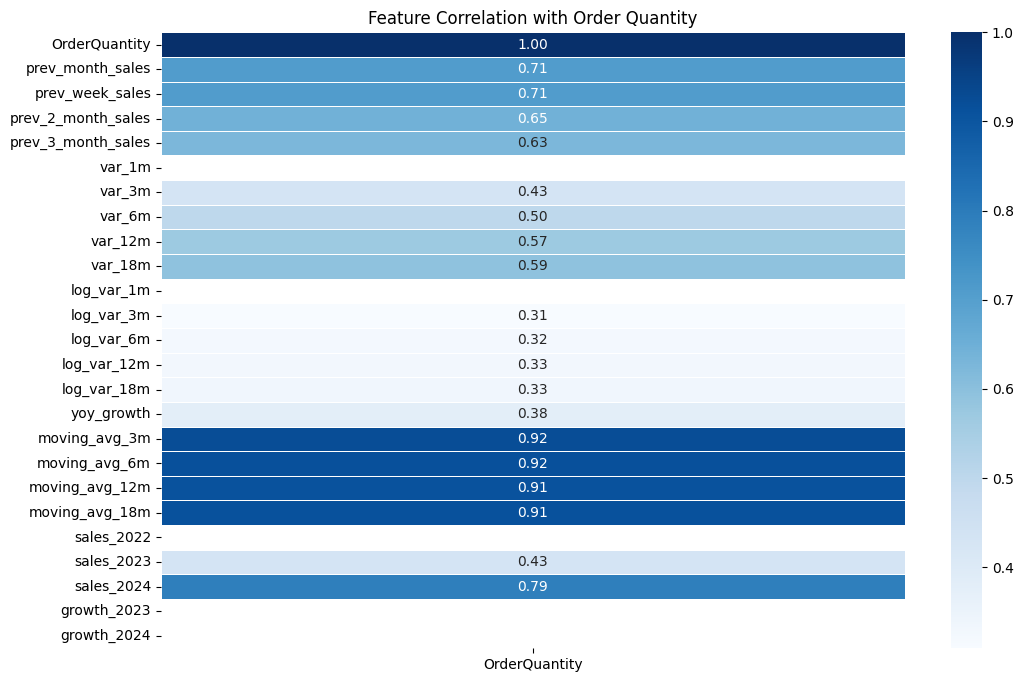

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numerical features
numerical_features = [
    'OrderQuantity', 'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 
    'prev_3_month_sales', 'var_1m', 'var_3m', 'var_6m', 'var_12m', 'var_18m', 
    'log_var_1m', 'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m', 
    'yoy_growth', 'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m', 
    'sales_2022', 'sales_2023', 'sales_2024', 'growth_2023', 'growth_2024'
]

# Compute correlation matrix
corr_matrix = custom_code_df[numerical_features].corr()

# Create heatmap
plt.figure(figsize=(12, 8))  # Adjust size for better readability
sns.heatmap(corr_matrix[['OrderQuantity']], cmap='Blues', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with Order Quantity")
plt.show()

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = custom_code_df.copy()

features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features)  # one-hot encode categorical features
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.append('../src')
from model_utils import find_best_hyperparameters, param_grids, evaluate_model
from model_utils import evaluate_sarima_model

In [10]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [11]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [12]:
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 5553.3228
Mean Squared Error (MSE): 584871441.8540
Root Mean Squared Error (RMSE): 24184.1155
R-squared (R²): 0.9575
--------------------------------------------


In [13]:
import pandas as pd

# handle potential column duplication during merge
product_sales = product_sales.drop(columns=['PhysicalInv'], errors='ignore')  # Drop the column if it exists
product_sales = pd.merge(product_sales, products_s[['ProductNumber', 'PhysicalInv']], on='ProductNumber')

# prepare sales data for SARIMAX model
merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'])  # Convert 'OrderDate' to datetime format

# set index for time series modeling
sales_data = df.set_index(['OrderDate', 'ProductNumber'])
sales_data = sales_data['OrderQuantity']  # Focus on the 'OrderQuantity' column for the analysis

# resample the data to a monthly frequency and aggregate the order quantity
sales_data = sales_data.reset_index(level='ProductNumber')  # Reset the 'ProductNumber' index level
sales_data = sales_data.resample('M').sum()  # Aggregate by month ('M' for monthly)

# handle missing data (if any)
sales_data['OrderQuantity'].fillna(0, inplace=True)  # Fill missing order quantities with 0 (if any)

# split data into training and testing sets
train_size = int(len(sales_data) * 0.8)  # 80% for training, 20% for testing
train, test = sales_data.iloc[:train_size], sales_data.iloc[train_size:]

evaluate_sarima_model(sales_data, train, test)

KeyError: "None of ['OrderDate'] are in the columns"

In [ ]:
# NN imports
from sklearn.model_selection import GridSearchCV, cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

# NN METRICS ARE NOT ARENT BETTER THAN BASE MODELS, SO ITS COMMENTED OUT

# neural network model
def create_nn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# KerasRegressor
input_shape = X_train_scaled.shape[1]
nn_model = KerasRegressor(build_fn=create_nn_model, input_shape=input_shape, verbose=1)

grid_search = GridSearchCV(estimator=nn_model, param_grid=param_grids(nn_model.__class__.__name__), cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

nn_params = grid_search.best_params_
print(f'Best Parameters: {nn_params}')

nn_model.set_params(**nn_params)

# print scores for each cross validation
scores = cross_val_score(nn_model, X_train_scaled, y_train, cv=5)
print(scores)

# train
history = nn_model.fit(X_train_scaled, y_train, epochs=nn_params['epochs'], batch_size=nn_params['batch_size'], validation_split=0.2, verbose=1)

y_pred_nn = nn_model.predict(X_val_scaled)

evaluate_model(nn_model, X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END batch_size=64, epochs=200, loss=mean_squared_error, optimizer=adam, random_state=42, shuffle=True, verbose=1; total time=   0.0s
[CV] END batch_size=64, epochs=200, loss=mean_squared_error, optimizer=adam, random_state=42, shuffle=True, verbose=1; total time=   0.0s
[CV] END batch_size=64, epochs=200, loss=mean_squared_error, optimizer=adam, random_state=42, shuffle=True, verbose=1; total time=   0.0s
[CV] END batch_size=64, epochs=200, loss=mean_squared_error, optimizer=adam, random_state=42, shuffle=True, verbose=1; total time=   0.0s
[CV] END batch_size=64, epochs=200, loss=mean_squared_error, optimizer=adam, random_state=42, shuffle=True, verbose=1; total time=   0.0s


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py", line 925, in _fit
    X, y = self._initialize(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py", line 853, in _initialize
    X, y = self._validate_data(X, y, reset=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py", line 1733, in _validate_data
    return super()._validate_data(X=X, y=y, reset=reset, y_numeric=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py", line 626, in _validate_data
    X, y = check_X_y(
           ^^^^^^^^^^
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.


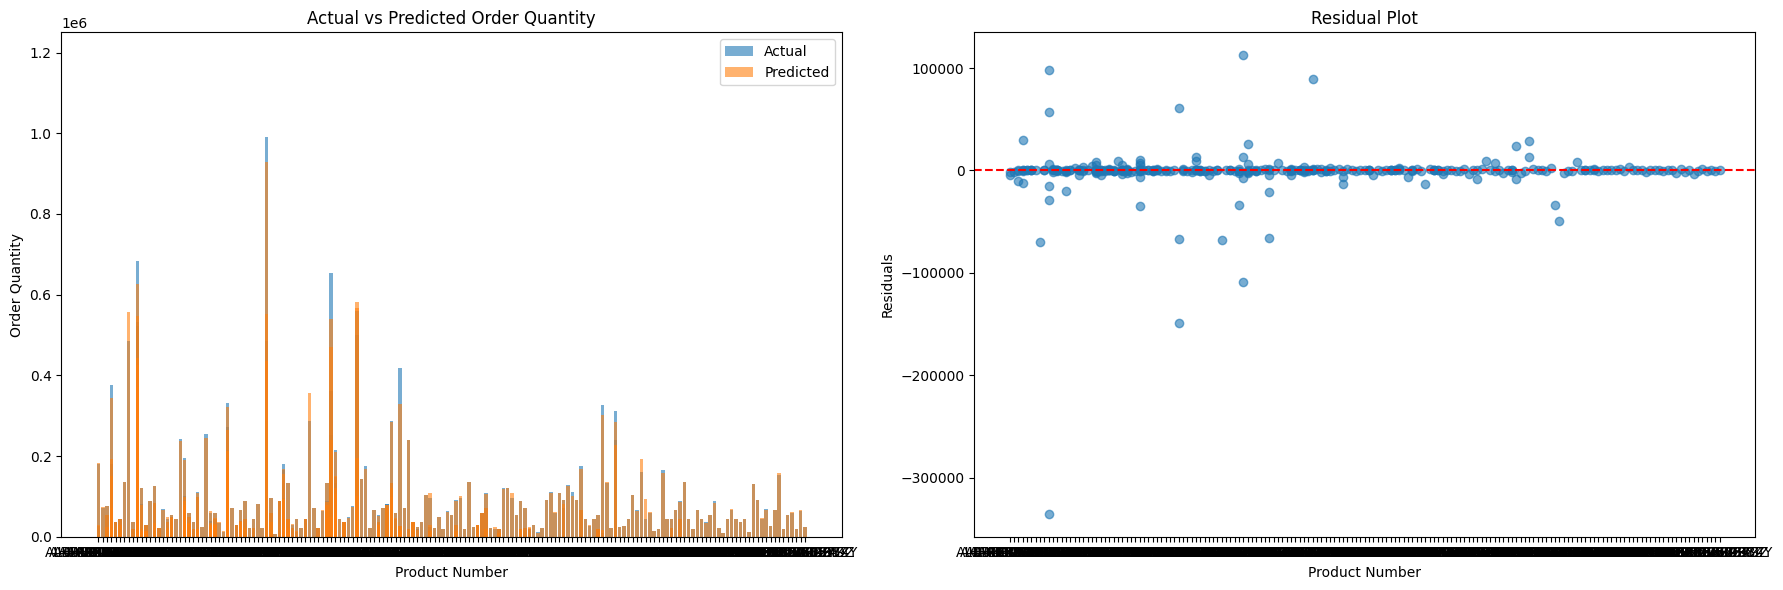

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# bar plot, actual and predicted values
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title('Actual vs Predicted Order Quantity')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# residual plot
residuals = y_val - y_pred_rf
axes[1].scatter(product_sales.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

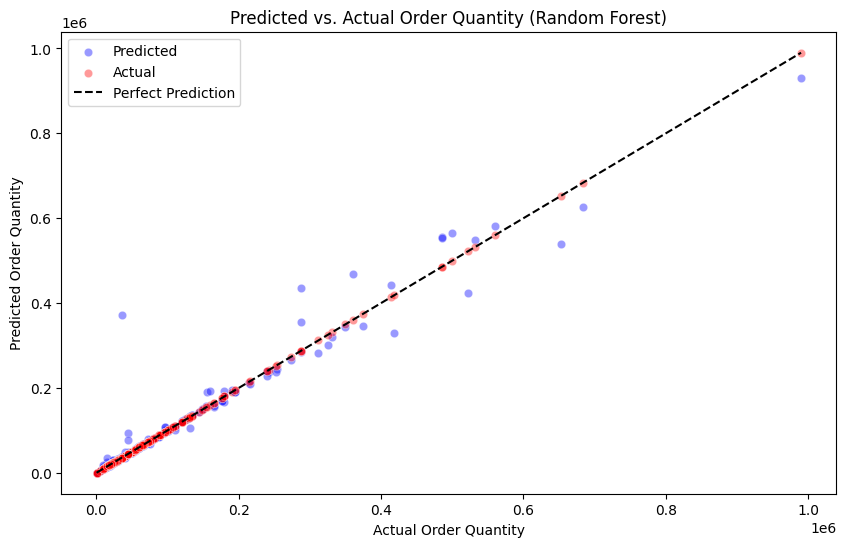

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='red', label='Actual')  

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title("Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()